# 

In [22]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.stats as stats

import fitsio
import xlens

import tables_io
import h5py
from astropy.table import Table
from astropy.stats import biweight_location, biweight_scale
from scipy.stats import sigmaclip
from matplotlib import cm

# =============================
# Matplotlib defaults
# =============================
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14
plt.rc("font", size=BIGGER_SIZE)
plt.rc("axes", titlesize=BIGGER_SIZE)
plt.rc("axes", labelsize=BIGGER_SIZE)
plt.rc("xtick", labelsize=BIGGER_SIZE)
plt.rc("ytick", labelsize=BIGGER_SIZE)
plt.rc("legend", fontsize=BIGGER_SIZE)
plt.rc("figure", titlesize=BIGGER_SIZE)

In [2]:
pscratch= "/gpfs02/astro/workarea/xli6/"
Dir = os.path.join(
    pscratch,
    "work/DP1/"
)
rail_pz_h5 = os.path.join(
    Dir, "photoz",
    "fzb_6bands/projects/com_cam/data/gold_rubin/output_estimate_fzboost.hdf5",
)

MODEL_PATH = os.path.join(
    Dir, "photoz",
    "fzb_6bands/projects/com_cam/data/gold_rubin/model_inform_fzboost.pkl",
)

In [3]:
data_fname = os.path.join(Dir, "rail_data", "data_edfs_with_mag.hdf5")
df = tables_io.read(
    data_fname,
    tType="astropyTable",
)
train_fname = os.path.join(Dir, "rail_data", "train_with_mag.hdf5")
df_train = tables_io.read(
    train_fname,
    tType="astropyTable",
)
df = df[df["i_mag_gauss2"] < 25.5]
df_train = df_train[df_train["i_mag_gauss2"] < 25.5]

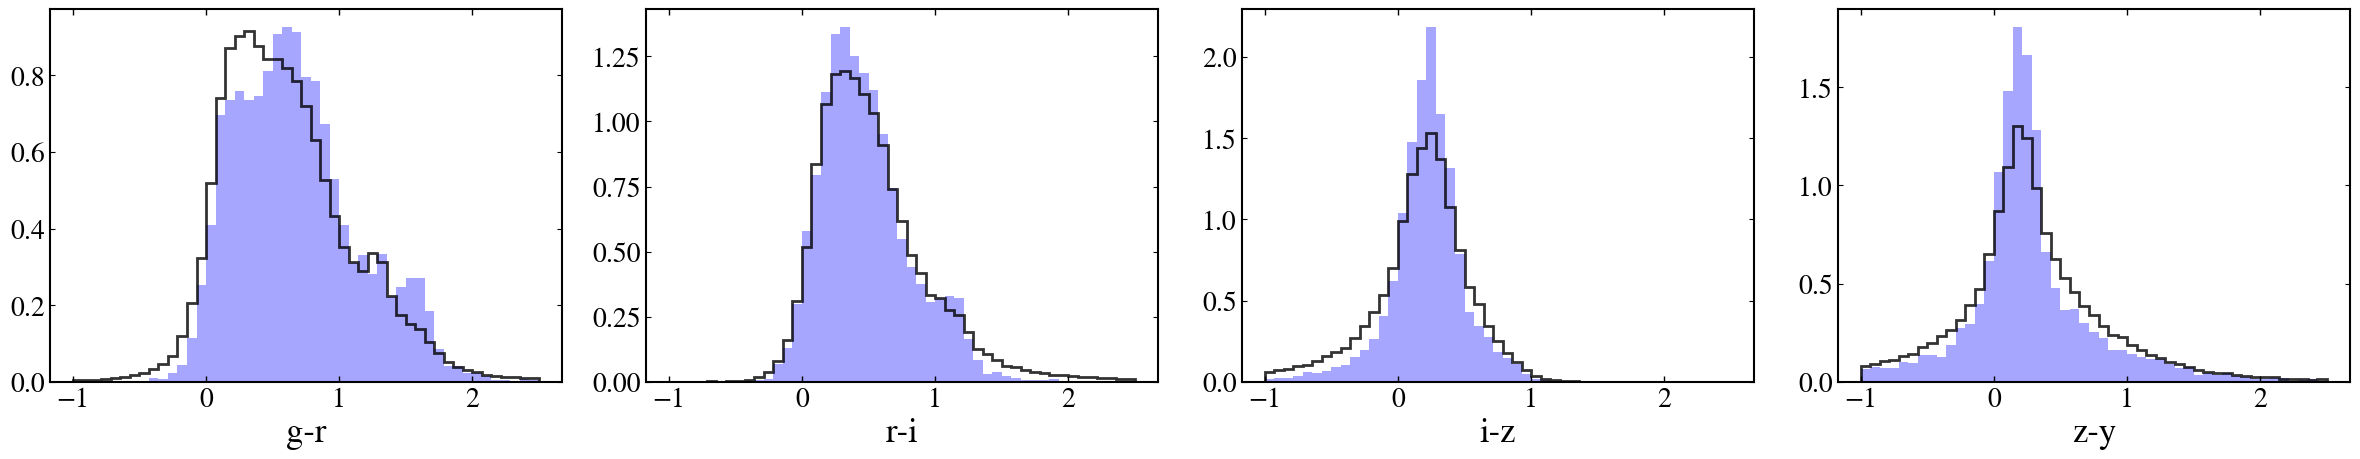

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))
xbins = np.linspace(0, 4, 14)
magbins = np.linspace(14, 26.0, 52)
colorbins = np.linspace(-1, 2.5, 50)
bands = "grizy"
for i in range(4):
    bandi = bands[i]
    bandj = bands[i + 1]
    xi = f"{bandi}_mag_gauss2"
    xj = f"{bandj}_mag_gauss2"
    axs[i].hist(df_train[xi] - df_train[xj], bins=colorbins, alpha=0.35, color="b", density=True)
    axs[i].hist(df[xi] - df[xj], bins=colorbins, alpha=0.8, color="k", density=True, histtype="step", linewidth=2.0)
    axs[i].set_xlabel(f"{bandi}-{bandj}", fontsize=25)
plt.tight_layout()

In [5]:
msk = (
    (df["u_mag_gauss2"] < 26.4) & 
    (df["g_mag_gauss2"] < 27.8) & 
    (df["r_mag_gauss2"] < 27.1) & 
    (df["i_mag_gauss2"] < 24.5) & 
    (df["z_mag_gauss2"] < 25.8) & 
    (df["y_mag_gauss2"] < 24.6) &
    ((df["i_fpfs1_m00"] + df["i_fpfs1_m20"]) / df["i_fpfs1_m00"] > 0.1) &
    ((df["i_fpfs1_m00"] + df["i_fpfs1_m20"]) / df["i_fpfs1_m00"] < 1.5)
)

(18.0, 25.0)

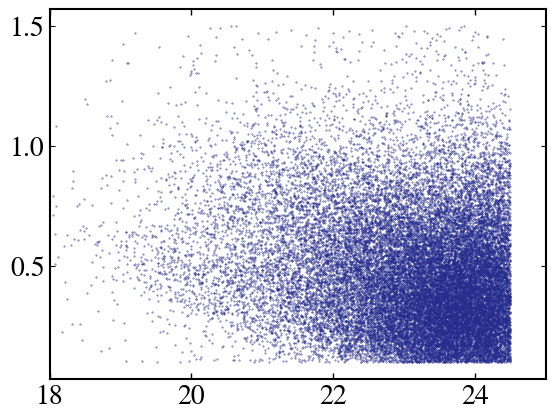

In [6]:
size = (df["i_fpfs1_m00"] + df["i_fpfs1_m20"]) / df["i_fpfs1_m00"]
# remove stars in the catalog with resolution cut
plt.scatter(df["i_mag_gauss2"][msk], size[msk], s=0.1)
plt.xlim(18, 25.0)

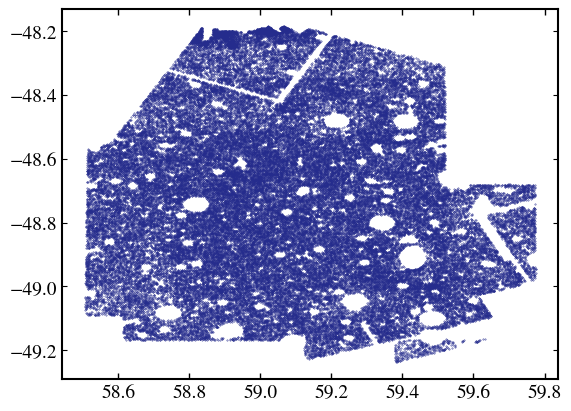

In [107]:
mm = (df["ra"] - 59.428) ** 2.0 + (df["dec"] + 48.908) ** 2.0 > 0.0015
plt.scatter(df["ra"][mm], df["dec"][mm], s=0.1)

In [8]:
zfname = os.path.join(Dir, "rail_data", "data_edfs_redshift.hdf5")
if False:
    import pickle
    with open(MODEL_PATH, "rb") as f:
        pz_obj = pickle.load(f)
    fzbobj = xlens.catalog.redshift.flexzboostEstimator(pz_obj)
    redshift = fzbobj.get_z(
        df.as_array(),
        mag_zero=31.4,
        flux_name="gauss2",
        bands="ugrizy",
        ref_band="i",
    )
    tables_io.write(redshift, zfname)
else:
    redshift = tables_io.read(
        zfname,
        tType="astropyTable",
    )

In [10]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

z_cl = 0.7

# source properties
# assume sources redshift following a the DESC SRD distribution. This will need updating.

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

arcsec = 1 / 60**2
rng = np.random.default_rng()
omega_m = .31
omega_de= .69
omega_r = 0
H0 = 70 # km/s/Mpc
c = 3e5 # km/s

Hz = lambda z : c/(H0  * np.sqrt((omega_de + omega_m * (1+z)**3 + omega_r * (1+z)**4)))
chi_dl = lambda z, z0=0 : integrate.quad(Hz, z0, z)[0]
Da = lambda z : chi_dl(z)/(1+z)
beta_r = lambda zl, zs : integrate.quad(Hz, zl, zs)[0]/integrate.quad(Hz, 0, zs)[0]

def fast_bootstrap_mean(data, n_resamples=2000, ci_level=0.95):
    n = len(data)
    means = np.empty(n_resamples)
    for i in range(n_resamples):
        sample = np.random.choice(data, size=n, replace=True)
        means[i] = np.mean(sample)
    alpha = 1.0 - ci_level
    lower = np.percentile(means, 100 * alpha / 2)
    upper = np.percentile(means, 100 * (1 - alpha / 2))
    return np.array([lower, upper])
    
def anacal_get_tang_cross(cluster, sky_dist, bins, R, ci_level=.95):
    nb = len(bins) - 1
    res_avg = np.zeros(nb)
    res_err = np.zeros((nb, 2))
    
    tang_avg = np.zeros(nb)
    cross_avg = np.zeros_like(tang_avg)

    tang_err = np.zeros((nb, 2))
    cross_err = np.zeros_like(tang_err)

    bin_rs = []
    R_correction2 = np.mean(R) 
    
    for i in range(nb):
        # bin_rs.append(bins[i])
        ndx_filt = (sky_dist > bins[i]) * (sky_dist < bins[i+1])
        bin_rs.append(np.where(ndx_filt)[0])
        if np.sum(ndx_filt) < 1:
            continue
            
        sample = cluster[ndx_filt]
        sample_t = sample.real
        sample_x = sample.imag

        sr = R[ndx_filt] 
        print(np.sum(ndx_filt))
        R_correction = np.mean(sr)
        ta = np.mean(sample_t)/R_correction2
        xa = np.mean(sample_x)/R_correction2
        
        re = fast_bootstrap_mean(sr, ci_level=ci_level, n_resamples=500)
        te = fast_bootstrap_mean(sample_t, ci_level=ci_level, n_resamples=500)
        xe = fast_bootstrap_mean(sample_x, ci_level=ci_level, n_resamples=500)
        
        res_avg[i] = R_correction
        res_err[i] = re
        tang_avg[i] = ta
        cross_avg[i] = xa
        tang_err[i] = te / R_correction2
        cross_err[i] = xe / R_correction2
    return tang_avg, cross_avg, tang_err, cross_err, bin_rs, res_avg, res_err

In [156]:
msk = (
    (df["u_mag_gauss2"] < 27.5) & 
    (df["g_mag_gauss2"] < 27.5) & 
    (df["r_mag_gauss2"] < 24.5) & 
    (df["i_mag_gauss2"] < 27.5) & 
    (df["z_mag_gauss2"] < 27.5) & 
    (df["y_mag_gauss2"] < 27.5) &
    ((df["i_fpfs1_m00"] + df["i_fpfs1_m20"]) / df["i_fpfs1_m00"] > 0.1) &
    (redshift["zmode"] > 0.75) &
    ((df["ra"] - 59.428) ** 2.0 + (df["dec"] + 48.908) ** 2.0 > 0.0015)
)
df2 = df[msk]

In [157]:
c0 = 50.0
weights = {
    "g": 0.10110928,
    "r": 0.290752, 
    "i": 0.51740466 , 
    "z": 0.09073406,
}
m22c = np.zeros(len(df2))
dm22c_dg1 = np.zeros(len(df2))
m22s = np.zeros(len(df2))
dm22s_dg2 = np.zeros(len(df2))
m00 = np.zeros(len(df2))
dm00_dg1 = np.zeros(len(df2))
dm00_dg2 = np.zeros(len(df2))
for band in ["g", "r", "i", "z"]:
    w = weights[band]
    m22c = m22c + df2[f"{band}_fpfs1_m22c"] * w
    m22s = m22s + df2[f"{band}_fpfs1_m22s"] * w
    m00 = m00 + df2[f"{band}_fpfs1_m00"] * w
    dm22c_dg1 = dm22c_dg1 + df2[f"{band}_fpfs1_dm22c_dg1"] * w
    dm22s_dg2 = dm22s_dg2 + df2[f"{band}_fpfs1_dm22s_dg2"] * w
    dm00_dg1 = dm00_dg1 + df2[f"{band}_fpfs1_dm00_dg1"] * w
    dm00_dg2 = dm00_dg2 + df2[f"{band}_fpfs1_dm00_dg2"] * w
e1 = m22c / (m00 + c0) * df2["wsel"]
e2 = m22s / (m00 + c0) * df2["wsel"]
de1_dg1 = dm22c_dg1 / (m00 + c0) - m22c / (m00 + c0)**2.0 * dm00_dg1
de2_dg2 = dm22s_dg2 / (m00 + c0) - m22s / (m00 + c0)**2.0 * dm00_dg2
res = (
    de1_dg1 * df2["wsel"] + df2["dwsel_dg1"]* m22c / (m00 + c0) +
    de2_dg2 * df2["wsel"] + df2["dwsel_dg2"]* m22s / (m00 + c0)
) / 2.0

In [158]:
cluster_coords = (59.487317, -49.000349)
ra_bcg = cluster_coords[0]
dec_bcg = cluster_coords[1]
source_phi = np.arctan2(df2['dec'] - cluster_coords[1], (cluster_coords[0] - df2['ra'])*np.cos(np.deg2rad(cluster_coords[1])))
ang_dist = np.sqrt(((df2['ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (df2['dec'] - cluster_coords[1])**2)
sky_distance = Da(z_cl) * ang_dist * (np.pi/180)

trial_shear = e1 + 1.j*e2
cl_shear = trial_shear * -1*np.exp(-2j*source_phi)

bins_mpc = clmm.make_bins(0.3,7,nbins=5, method='evenlog10width')
bin_mids = 1/2 * (bins_mpc[1:] + bins_mpc[:-1])
shear_cl = anacal_get_tang_cross(cl_shear, sky_distance, bins_mpc, res, ci_level=.68)

moo = clmm.Modeling(massdef="critical", delta_mdef=500, halo_profile_model="nfw")
moo.set_cosmo(cosmo)
moo.set_concentration(4)
moo.set_mass(3e14)

rproj = np.logspace(np.log10(0.4),np.log10(7.), 100)
gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

27
75
256
686
1563


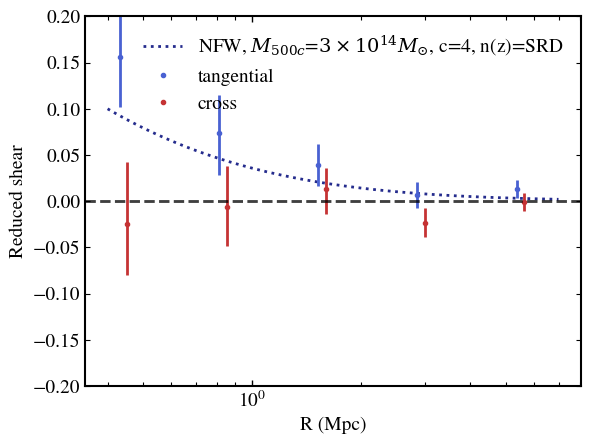

In [159]:
plt.close()
cmap = cm.coolwarm

plt.plot(rproj, gt_z, label=r'NFW, $M_{500c}$=$3 \times 10^{14} M_{\odot}$, c=4, n(z)=SRD', ls=':')
plt.plot(bin_mids, shear_cl[0], '.', label='tangential', color=cmap(.05))
plt.vlines(bin_mids, shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05))

plt.plot(1.05*bin_mids, shear_cl[1], '.', label='cross', color=cmap(.95))
plt.vlines(1.05*bin_mids, shear_cl[3][:,0], shear_cl[3][:,1], color=cmap(0.95))
plt.axhline(0, ls='--', color='k', alpha=.5)

plt.semilogx()
plt.axhline(0, ls='--', color='k', alpha=.5)
plt.ylim([-0.2,0.2])
plt.ylabel("Reduced shear")
plt.xlabel("R (Mpc)")
plt.legend(frameon=False, loc='upper right')